# Distinguishing different sports - using PyTorch

In [1]:
import torch 
import torch.nn as nn
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F

import os
import numpy as np
np.set_printoptions(precision = 3)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_epochs = 20
batch_size = 10
learning_rate = 0.001
dropout = 0.5
num_classes = 6

In [3]:
model_name = "cnn_pytorch_50epochs.pt"
model_exists = True

In [4]:
data_dir = 'data'

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale((224,224)),
        # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor
        # of shape (C x H x W) in the range [0.0, 1.0].
        transforms.ToTensor(),
        # https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/6
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Scale((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
image_datasets

{'test': <torchvision.datasets.folder.ImageFolder at 0x7f500299c240>,
 'train': <torchvision.datasets.folder.ImageFolder at 0x7f5002c70eb8>}

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True)
              for x in ['train', 'test']}
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f5002c702b0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f5002c70240>}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
dataset_sizes

{'test': 1775, 'train': 7096}

In [7]:
class_names = image_datasets['train'].classes
class_names

['climbing', 'cycling', 'gymnastics', 'rowing', 'skating', 'xc_skiing']

In [8]:
class Convnet (nn.Module):
    
    def __init__(self):
        super(Convnet, self).__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, padding = 1)
        self.conv4_bn = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.out = nn.Linear(256, num_classes)
        
    def forward(self, x):
        mu = 0
        sd = 0
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.dropout(F.relu(self.fc1(x)), dropout)
        x = self.out(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



In [9]:
cnn = Convnet()
print(cnn)

Convnet (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (100352 -> 256)
  (out): Linear (256 -> 6)
)


In [10]:
params = list(cnn.parameters())
[p.size() for p in params]

[torch.Size([32, 3, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([256, 100352]),
 torch.Size([256]),
 torch.Size([6, 256]),
 torch.Size([6])]

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [12]:
if not model_exists:
    for epoch in range(num_epochs):
        
        epoch_loss = 0

        for i, (images, labels) in enumerate(dataloaders["train"]):
            images = Variable(images)
            labels = Variable(labels)

            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            batch_loss = loss.data
            epoch_loss += batch_loss

        epoch_loss = epoch_loss / (dataset_sizes["train"]//batch_size)
        print ("Epoch {}: Loss: {}".format(epoch, epoch_loss[0]))

    torch.save(cnn, model_name) 

In [13]:
if model_exists:
    cnn = torch.load(model_name)
    

In [14]:
cnn.eval() # Change model to 'eval' mode (batch normalization uses moving avg/var).

Convnet (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (100352 -> 256)
  (out): Linear (256 -> 6)
)

In [15]:
correct = 0
total = 0

for (images, labels) in dataloaders["test"]:
    images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


In [16]:
print('Test Accuracy:  {}'.format(correct / total))

Test Accuracy:  0.64


In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


True class: xc_skiing
Predicted class: rowing


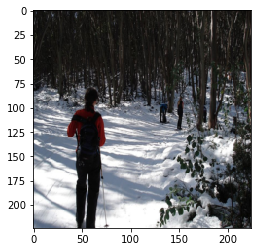

In [18]:
dataiter = iter(dataloaders["test"])
images, labels = dataiter.next()
true_class = class_names[labels[0]]
print("True class: {}".format(true_class))
output = (cnn(Variable(images)))[0, :]
#print(output)
prob, predicted_class = torch.max(output.data, 0)
print('Predicted class: {}'.format(class_names[predicted_class[0]]))
imshow(images[0, : , : , : ])


In [19]:
confusion_matrix_test = np.zeros((num_classes, num_classes), np.int32)

for data in dataloaders["test"]:
    images, labels = data
    outputs = cnn(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    for index, value  in enumerate(labels):
        true = value
        pred = predicted[index]
        confusion_matrix_test[true, pred[0]] += 1
        
confusion_matrix_test

/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


array([[207,  33,  23,  18,   2,   7],
       [ 31, 200,  30,  19,  15,  19],
       [ 11,  25, 286,  14,  29,  25],
       [ 20,  22,  31, 190,  11,  13],
       [  9,  50,  43,   6,  50,  56],
       [ 10,  18,  17,  10,  22, 203]], dtype=int32)